In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch

if torch.cuda.is_available():
    device_wta = torch.device("cuda:0")
    device_cnp = torch.device("cuda:1") if torch.cuda.device_count() > 1 else torch.device("cuda:0")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

In [2]:
batch_size = 2
n_max_obs, n_max_tar = 6, 6

t_steps = 200
num_demos = 8
num_classes = 2
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 4
num_val_indiv = num_val//num_classes

colors = ['r', 'b']

X: torch.Size([8, 200, 1]) Y: torch.Size([8, 200, 1]) VX: torch.Size([4, 200, 1]) VY: torch.Size([4, 200, 1])


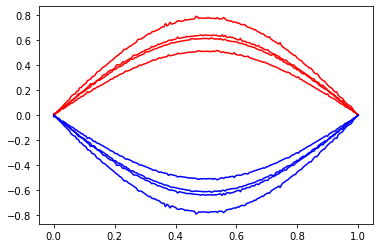

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

noise = torch.clamp(torch.randn(x.shape)*1e-7**0.5, min=0) - noise_clip
coeff = (torch.rand(num_indiv)*0.75+0.25).unsqueeze(-1)
y[:num_indiv] = torch.unsqueeze(generate_sin(x)*coeff + noise, 2)
y[num_indiv:] = -1 * y[:num_indiv]

coeff = (torch.rand(num_val_indiv)*0.75+0.25).unsqueeze(-1)
noise = torch.clamp(torch.randn(vx.shape)*1e-7**0.5, min=0) - noise_clip
vy[:num_val_indiv] = torch.unsqueeze(generate_sin(vx)*coeff + noise, 2)
vy[num_val_indiv:] = -1 * vy[:num_val_indiv]

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

from matplotlib import pyplot as plt

for i in range(num_demos):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), colors[i//num_indiv])


x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [4]:
def get_batch(x, y, traj_ids, device=device_wta):
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    n_o = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    # print("Obs:", obs.shape, "Tar:", tar.shape, "Tar_val:", tar_val.shape)
    return obs, tar, tar_val

def get_validation_batch(vx, vy, o_ids=[0, -1], device=device_wta):
    traj_ids = torch.randperm(num_val)[:batch_size]
    num_obs = len(o_ids)

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids, :], vy[traj_ids[i], o_ids, :]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]
    # obs = torch.cat((vx[trajectory_ids, o_ids, :], vy[trajectory_ids, o_ids, :]), dim=-1).to(device)
    # tar = vx[trajectory_ids, torch.arange(t_steps)].to(device)
    # tar_val= vy[trajectory_ids, torch.arange(t_steps)].to(device)

    return obs, tar, tar_val

In [5]:
model_wta = WTA_CNP(1, 1, 10, 10, [256, 256, 256], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=287, output_dim=1, n_max_obs=10, n_max_tar=10, num_layers=2, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

WTA-CNP: 199430
CNP: 167036


In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/diff/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')


epochs = 1000000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, device=device_wta)
o_cnp, t_cnp, tr_cnp = get_validation_batch(vx, vy, device=device_cnp)

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = get_batch(x, y, traj_ids[i], device_cnp)

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)
        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            p_wta, g_wta = model_wta(o_wta, t_wta)
            # dec_id = torch.zeros_like(g, device=device)
            dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
            vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
            val_loss_wta = mse_loss(vp_means, tr_wta).item()
            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
            val_loss_cnp = mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)
            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % 100 == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/100, avg_loss_cnp/100))
        avg_loss_wta, avg_loss_cnp = 0, 0

    if epoch % 100000:
        torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
        torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
        torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
        torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.19763575494289398
(CNP)New best: 0.19579383730888367
Epoch: 0, WTA-Loss: 0.031938968896865844, CNP-Loss: 0.03106635332107544
Epoch: 100, WTA-Loss: 0.25003542663762346, CNP-Loss: 0.16909551758784802
Epoch: 200, WTA-Loss: -0.219798503681086, CNP-Loss: -0.1790338826077641
Epoch: 300, WTA-Loss: -0.3059401962067932, CNP-Loss: -0.2707629221933894
Epoch: 400, WTA-Loss: -0.222591686504893, CNP-Loss: -0.2585414323816076
Epoch: 500, WTA-Loss: -0.38887276194058357, CNP-Loss: -0.22502757870359347
Epoch: 600, WTA-Loss: -0.4228333273064345, CNP-Loss: -0.3961989439709578
Epoch: 700, WTA-Loss: -0.37958151401486245, CNP-Loss: -0.4497526162734721
Epoch: 800, WTA-Loss: -0.47580369930714367, CNP-Loss: -0.4412423579234746
Epoch: 900, WTA-Loss: -0.4932694803061895, CNP-Loss: -0.44459023837931455
Epoch: 1000, WTA-Loss: -0.5158211656939238, CNP-Loss: -0.49714353079209106
Epoch: 1100, WTA-Loss: -0.4898041816940531, CNP-Loss: -0.4547266380023211
Epoch: 1200, WTA-Loss: -0.4989186683297157, CNP-L